In [1]:
from autoencoder import autoencoder_model
from gan import DCGAN, discriminator_model, generator_model
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import yfinance as yf
from scipy.spatial import distance
import mplfinance as mpf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector, make_column_transformer

/Users/ryousukekaga/repositories/forex-analysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
WINDOW = 64
Z_DIM = 100
NUM_FEATURES = 4

In [3]:
data = pd.read_table("../data/USDJPY_D1.csv", names=["datetime", "open", "high", "low", "close", "volume"])
data.drop("volume", inplace=True, axis=1)
num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    MinMaxScaler()
)

dates = data["datetime"]

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    verbose_feature_names_out=False
)

num_data = data.select_dtypes(include="number")

windows = list(num_data.rolling(window=WINDOW))[WINDOW:]
windows = np.array([preprocessing.fit_transform(d) for d in windows])

In [4]:
data.index = pd.date_range(dates[0], periods=(data.shape[0]))

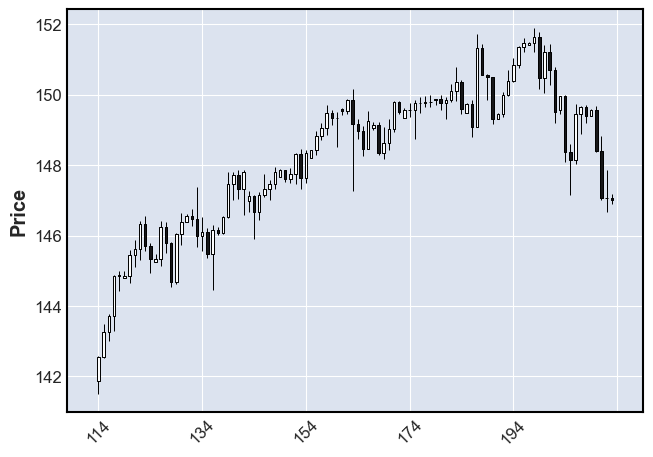

In [5]:
mpf.plot(data[-100:], type='candle', datetime_format='%j')

In [7]:
encoder, decoder, autoencoder = autoencoder_model(WINDOW, Z_DIM, NUM_FEATURES)

if not os.path.exists(f"autoencoder_window_{WINDOW}.h5"):
    optimizer = Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=optimizer, loss="binary_crossentropy")
    autoencoder.fit(windows, windows, epochs=30, batch_size=32, shuffle=True)
    autoencoder.save_weights(f"autoencoder_window_{WINDOW}.h5")

autoencoder.load_weights(f"autoencoder_window_{WINDOW}.h5")
embeddings = encoder.predict(windows)

Epoch 1/30
155/155 [==============================] - 2s 6ms/step - loss: 0.8502
Epoch 2/30
155/155 [==============================] - 1s 8ms/step - loss: 0.6351
Epoch 3/30
155/155 [==============================] - 1s 9ms/step - loss: 0.6184
Epoch 4/30
155/155 [==============================] - 1s 8ms/step - loss: 0.6151
Epoch 5/30
155/155 [==============================] - 1s 9ms/step - loss: 0.5978
Epoch 6/30
155/155 [==============================] - 2s 10ms/step - loss: 0.5766
Epoch 7/30
155/155 [==============================] - 1s 9ms/step - loss: 0.5673
Epoch 8/30
155/155 [==============================] - 1s 9ms/step - loss: 0.5732
Epoch 9/30
155/155 [==============================] - 2s 10ms/step - loss: 0.5679
Epoch 10/30
155/155 [==============================] - 2s 10ms/step - loss: 0.5662
Epoch 11/30
155/155 [==============================] - 2s 10ms/step - loss: 0.5604
Epoch 12/30
155/155 [==============================] - 1s 9ms/step - loss: 0.5637
Epoch 13/30
155/155 [

In [8]:
ticker = yf.Ticker("JPY=X")
current_data = ticker.history(period="5y", interval="1d")[["Open", "High", "Low", "Close"]]
current_windows = np.array(list(current_data.rolling(window=WINDOW))[WINDOW:])
current_embeddings = encoder.predict(windows)

155/155 [==============================] - 0s 802us/step


In [13]:
distances = np.array([distance.cosine(embedding, current_embeddings[-1]) for embedding in embeddings])
idx = distances.argmin()

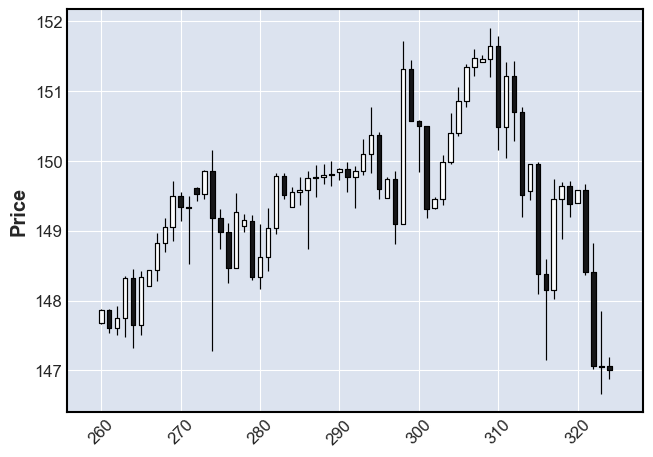

In [15]:
similar = data.iloc[idx:idx+WINDOW+10]
similar.index = pd.date_range(dates[idx], periods=(similar.shape[0]))
mpf.plot(similar, type='candle', datetime_format='%j')

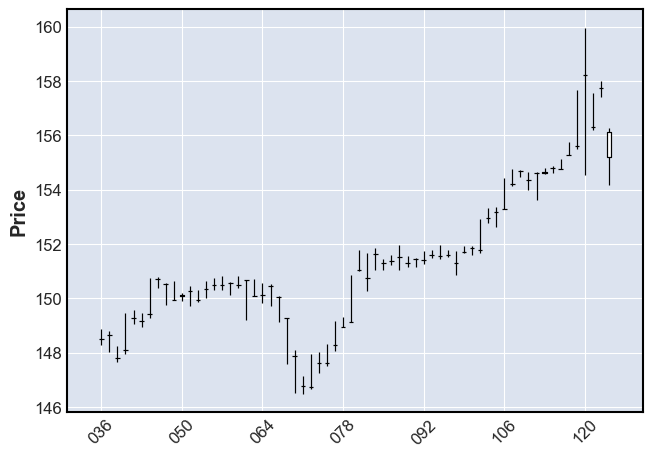

In [16]:
mpf.plot(current_data[-WINDOW:], type='candle', datetime_format='%j')